# 10-8. 프로젝트: 인물 모드 문제점 찾기

---

## 인물모드 직접 해 보기 & 사진에서 문제점 찾기

In [1]:
# library

import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e, "\n\n")
init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [3]:
# 모델 준비 : DeepLab model

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):    # 전처리 함수
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):    # 세그멘테이션 함수
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj24/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 1-1. 인물 사진

In [6]:
# 인물 사진 불러오기

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/min.jpeg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(675, 540, 3)


In [7]:
# 이미지 리사이즈

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(675, 540, 3) (513, 410, 3) 15


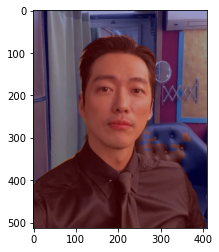

In [8]:
# 인물(사람) 검출

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

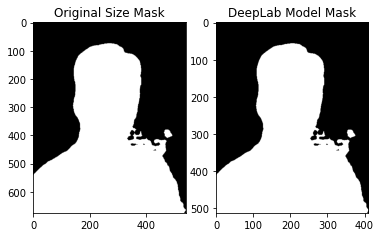

In [9]:
# 이미지 크기 복원

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

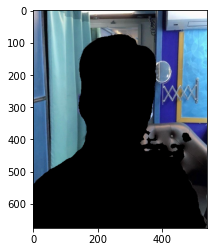

In [10]:
# 배경 추출

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

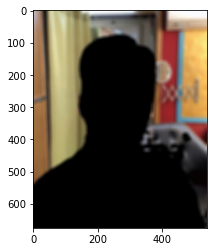

In [11]:
# 배경 블러(blur) 처리

img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

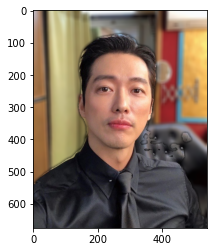

In [12]:
# 인물 검출 이미지와 배경 블러 처리된 이미지 합치기

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

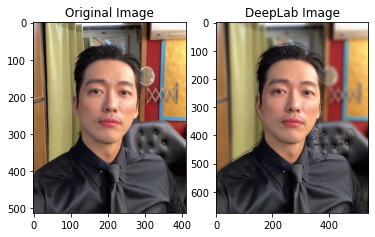

In [13]:
# 원본과 비교

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Original Image')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax.set_title('DeepLab Image')

plt.show()

### 1-2. DeepLab Image의 문제점
- 옷 색깔과 뒤에 있는 의자의 색깔이 비슷하기 때문인지 왼쪽 어깨 위 부분이 제대로 블러(blur) 처리 되지 않았다.

### 2-1. 동물 사진

In [14]:
# 동물 사진 불러오기

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bordercollie.jpeg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(800, 1280, 3)


In [15]:
# 이미지 리사이즈

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(800, 1280, 3) (320, 513, 3) 12


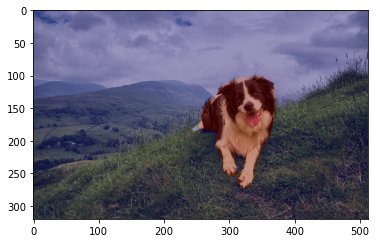

In [16]:
# 동물 검출

img_show = img_resized.copy()
seg_map = np.where(seg_map == 12, 12, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

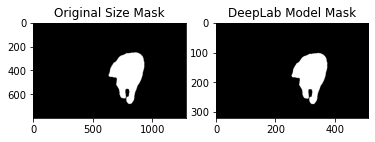

In [17]:
# 이미지 크기 복원

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

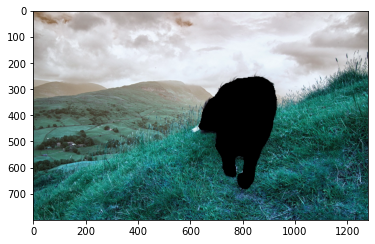

In [18]:
# 배경 추출

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

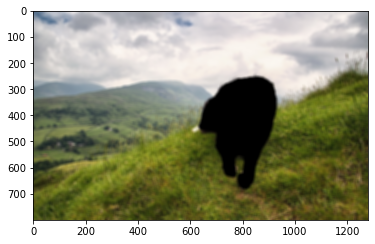

In [19]:
# 배경 블러(blur) 처리

img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

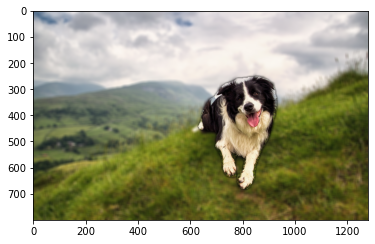

In [20]:
# 동물 검출 이미지와 배경 블러 처리된 이미지 합치기

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

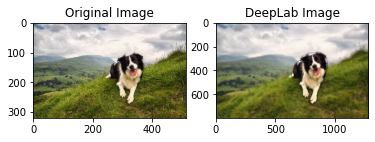

In [21]:
# 원본과 비교

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Original Image')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax.set_title('DeepLab Image')

plt.show()

### 2-2. DeepLab Image의 문제점
- 강아지가 앉은 자리 또한 배경으로 인식되어 블러(blur) 처리가 되는 바람에 자연스럽게 아웃포커싱 되지 않고 붕 떠있는 느낌이 드는 사진이 나왔다. (피사계 심도 문제)

### 3-1. 크로마키 배경 합성

In [22]:
# 인물 사진 불러오기

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/kang.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(2880, 5120, 3)


In [23]:
# 이미지 리사이즈

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(2880, 5120, 3) (288, 513, 3) 15


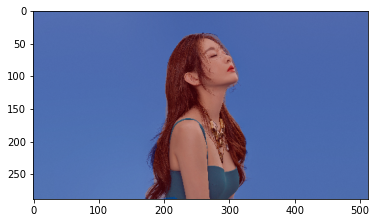

In [24]:
# 인물(사람) 검출

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

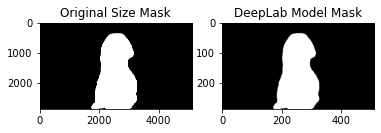

In [25]:
# 이미지 크기 복원

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

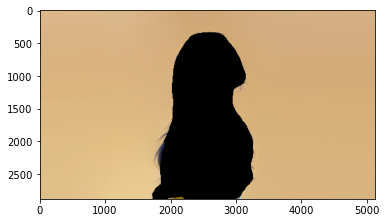

In [26]:
# 배경 추출

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

In [27]:
# 교체할 배경 불러오기

import os
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/whale.jpg' 
bg_img_orig = cv2.imread(bg_img_path) 
print (bg_img_orig.shape)

(576, 1024, 3)


In [28]:
# 교체할 배경 사이즈 맞추기

cd_bg_img = cv2.resize(bg_img_orig, img_mask_color.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
print(cd_bg_img.shape)

(2880, 5120, 3)


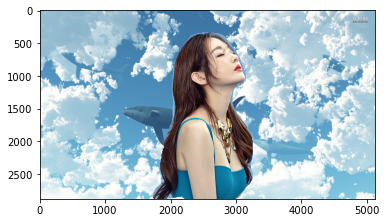

In [29]:
# 배경 교체

cd_dg_img_result = np.where(img_mask_color==255, img_orig, cd_bg_img)
plt.imshow(cv2.cvtColor(cd_dg_img_result, cv2.COLOR_BGR2RGB))
plt.show()

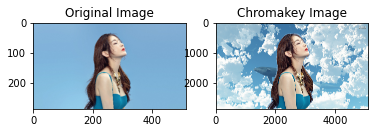

In [37]:
# 원본과 비교

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Original Image')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cd_dg_img_result, cv2.COLOR_BGR2RGB))
ax.set_title('Chromakey Image')

plt.show()

### 3-2. Chromakey Image의 문제점
- 깔끔한 배경 변환을 위해 배경이 단색으로 된 원본 사진으로 시도했지만 크로마키한 사진을 확인해 보면 인물 주변으로 띠가 형성되어 있다. 이것은 결국 Semantic segmentation 한계를 보여주는 것 같다. 

---

## 세그멘테이션의 한계 해결 방법 제안

### 3D Depth Camera 활용하기

- 카메라 모튤을 2대를 사용하여 픽셀의 깊이를 계산한 후 3D 이미지로 표현
- 스테레오, ToF, Structured Pattern 등 3가지 방식 모두 픽셀의 깊이 정보를 습득할 수 있기 때문에 기존의 한계를 벗어날 수 있다.

---

## 루브릭 평가

__1. 인물모드 사진을 성공적으로 제작하였다.__  
_(아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.)_

- 인물사진, 강아지 사진, 배경전화 크로마키 사진을 각 한장씩 제작하였다.

__2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.__  
_(인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.)_

- 원본과 비교해보며 발생한 문제점에 대하여 서술하였다.

__3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.__  
_(추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다)_

- 추가적인 depth 정보를 참고했지만 정확한 이해가 어려워 구체적인 솔루션을 제시하지 못했다.

---

## 회고

1. 프로젝트 진행시 어려웠던 점
2. 프로젝트를 진행하면서 알아낸 점 또는 아직 모호한 점
3. 루브릭 평가 지표를 맞추기 위해 시도한 점
4. 루브릭 평가 지표를 달성하지 못한 이유
5. 프로젝트 진행 후 느낀 점 및 다짐

>- DeepLab 모델의 코드가 어떻게 작동되는지 정확하게 이해하지 못했다.
>- 워터쉐드 세그멘테이션(watershed segmentation)의 한계점을 명확하게 알 수 있었다.
>- 사진 촬영에 관심이 있고 노드 자체도 비교적 이해하기 쉬워서 흥미롭게 진행할 수 있었다.